# 最小MLP（多層パーセプトロン）の実装

このノートブックでは、ディープラーニングの最も基本的なモデルである多層パーセプトロン（MLP）を、まずNumPyだけを使ってスクラッチで実装します。その後、同じモデルをPyTorchを使って実装し、両者を比較することで、フレームワークの役割や利便性を理解します。

**このノートブックで学ぶこと:**
1.  **NumPyによるMLPの実装:**
    *   順伝播（フォワードプロパゲーション）
    *   活性化関数（Sigmoid, ReLU）
    *   損失関数（平均二乗誤差, 交差エントロピー損失）
    *   逆伝播（バックプロパゲーション）の手動計算
    *   基本的な最適化アルゴリズム（確率的勾配降下法 - SGD）
2.  **PyTorchによるMLPの実装:**
    *   `torch.nn.Module` を使ったモデル定義
    *   `torch.autograd` による自動微分
    *   `torch.optim` を使った最適化
3.  **NumPy実装とPyTorch実装の比較:**
    *   コードの記述量、可読性
    *   勾配計算の自動化のメリット
    *   デバッグのしやすさなど

**前提知識:**
*   基本的なPythonプログラミング
*   NumPyの基本的な操作
*   線形代数の基礎（行列演算、ベクトルなど）
*   微分の基礎
*   機械学習の基本的な概念（訓練データ、テストデータ、損失関数、勾配降下法など）

## 1. NumPyによるMLPの実装

### 1.1 必要なライブラリのインポート

In [62]:
import numpy as np
import matplotlib.pyplot as plt

### 1.2 データセットの準備 (XOR問題)

MLPの能力を示す古典的な例として、XOR問題を扱います。XORは線形分離不可能な問題であり、単層パーセプトロンでは解けませんが、隠れ層を持つMLPであれば解くことができます。

*   入力: 2つのバイナリ値 (0 or 1)
*   出力: XORの結果 (0 or 1)

| X1 | X2 | Y  |
|----|----|----|
| 0  | 0  | 0  |
| 0  | 1  | 1  |
| 1  | 0  | 1  |
| 1  | 1  | 0  |

In [63]:
# XORデータセット
X_xor = np.array([[0, 0],
                  [0, 1],
                  [1, 0],
                  [1, 1]], dtype=np.float32)

y_xor = np.array([[0],
                  [1],
                  [1],
                  [0]], dtype=np.float32)

print("XOR入力データ (X_xor):\n", X_xor)
print("\nXOR出力データ (y_xor):\n", y_xor)

XOR入力データ (X_xor):
 [[0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 1.]]

XOR出力データ (y_xor):
 [[0.]
 [1.]
 [1.]
 [0.]]


### 1.3 MLPの構造

今回実装するMLPは以下の構造とします。
*   入力層: 2ユニット (XORの入力X1, X2に対応)
*   隠れ層: 任意ユニット数（例: 2ユニット）、活性化関数はSigmoidまたはReLU
*   出力層: 1ユニット (XORの出力Yに対応)、活性化関数はSigmoid（出力を0-1の確率として解釈するため）

### 1.4 主要コンポーネントの実装

#### 1.4.1 活性化関数 (Activation Functions)

活性化関数は、ニューロンの発火を模倣し、ネットワークに非線形性をもたらします。

*   **Sigmoid関数:**
    $\sigma(x) = \frac{1}{1 + e^{-x}}$
    出力は (0, 1) の範囲。主に二値分類の出力層や、古いスタイルの隠れ層で使われました。
    微分: $\sigma'(x) = \sigma(x)(1 - \sigma(x))$

*   **ReLU関数 (Rectified Linear Unit):**
    $\text{ReLU}(x) = \max(0, x)$
    計算が軽く、勾配消失問題を緩和する効果があるため、現代の多くのネットワークの隠れ層で標準的に使われます。
    微分: $\text{ReLU}'(x) = 1 \text{ if } x > 0 \text{ else } 0$

In [64]:
def sigmoid(x):
    '''Sigmoid関数'''
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    '''Sigmoid関数の導関数'''
    s = sigmoid(x) # xは活性化前
    return s * (1 - s)

def relu(x):
    '''ReLU関数'''
    return np.maximum(0, x)

def relu_derivative(x):
    '''Relu関数の導関数'''
    return np.where(x > 0, 1, 0)

In [65]:
# テスト
test_x = np.array([-2, -1, 0, 1, 2])
print("x:", test_x)
print("Sigmoid(x):", sigmoid(test_x))
print("Sigmoid_derivative(x):", sigmoid_derivative(test_x))
print("ReLU(x):", relu(test_x))
print("ReLU_derivative(x):", relu_derivative(test_x))

x: [-2 -1  0  1  2]
Sigmoid(x): [0.11920292 0.26894142 0.5        0.73105858 0.88079708]
Sigmoid_derivative(x): [0.10499359 0.19661193 0.25       0.19661193 0.10499359]
ReLU(x): [0 0 0 1 2]
ReLU_derivative(x): [0 0 0 1 1]


#### 1.4.2 損失関数 (Loss Functions)

損失関数は、モデルの予測と実際の値との間の誤差を測る尺度です。この損失を最小化するようにモデルのパラメータを学習します。

*   **平均二乗誤差 (Mean Squared Error - MSE):**
    $L_{MSE} = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2$
    主に回帰問題で使われます。
    出力層の活性化関数が恒等関数の場合、この損失関数の勾配はシンプルになります。
    今回は出力層がSigmoidなので、MSEを使う場合はそれも考慮した勾配計算が必要です。

*   **交差エントロピー損失 (Binary Cross-Entropy Loss):**
    $L_{BCE} = - \frac{1}{N} \sum_{i=1}^{N} [y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i)]$
    主に二値分類問題で、出力層の活性化関数がSigmoidの場合に使われます。
    この損失関数は、Sigmoid出力との組み合わせで勾配計算がシンプルになるという利点があります ($\hat{y} - y$)。

今回はXOR問題（二値分類）で、出力層の活性化関数をSigmoidとするため、**交差エントロピー損失**を使用するのが一般的です。簡単のため、まずは**平均二乗誤差 (MSE)** で実装し、その後交差エントロピーについても触れます。

In [66]:
def mean_squared_error(y_true, y_pred):
    '''平均二乗誤差'''
    return np.mean((y_true - y_pred)**2)

def binary_cross_entropy(y_true, y_pred):
    '''バイナリ交差エントロピー'''
    # log(0)を避けるための微小値を追加
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)  # 0や1にならないようにクリップ
    return -np.mean(y_true*np.log(y_pred) + (1 - y_true)*np.log(1 - y_pred))

In [67]:
# テスト
y_true_test = np.array([0, 1, 1, 0])
y_pred_test1 = np.array([0.1, 0.9, 0.8, 0.2])
y_pred_test2 = np.array([0.5, 0.5, 0.5, 0.5]) # 全て0.5と予測
print(f"MSE for pred1: {mean_squared_error(y_true_test, y_pred_test1):.4f}")
print(f"MSE for pred2: {mean_squared_error(y_true_test, y_pred_test2):.4f}") # こちらの方が誤差が大きい
print(f"BCE for pred1: {binary_cross_entropy(y_true_test, y_pred_test1):.4f}")
print(f"BCE for pred2: {binary_cross_entropy(y_true_test, y_pred_test2):.4f}") # こちらの方が誤差が大きい

MSE for pred1: 0.0250
MSE for pred2: 0.2500
BCE for pred1: 0.1643
BCE for pred2: 0.6931


#### 1.4.3 パラメータの初期化

ニューラルネットワークの重み($W$)とバイアス($b$)を初期化します。
重みの初期化は学習の成否に影響を与える重要な要素です。ここでは単純に小さな乱数で初期化します。

In [68]:
def initialize_parameters(input_size, hidden_size, output_size):
    '''
    MLPのパラメータを初期化する関数
    parameters:
        input_size: 入力層のノード数
        hidden_size: 隠れ層のノード数
        output_size: 出力層のノード数
    returns:
        dict: 初期化されたパラメータ（'W1', 'b1', 'W2', 'b2'）
    '''
    np.random.seed(42)  # 再現性のため
    
    # 入力層 -> 隠れ層
    W1 = np.random.randn(input_size, hidden_size) * 0.01 # 小さな値で初期化
    b1 = np.zeros((1, hidden_size))  # バイアスは0で初期化

    # 隠れ層 -> 出力層
    W2 = np.random.randn(hidden_size, output_size) * 0.01  # 小さな値で初期化
    b2 = np.zeros((1, output_size))  # バイアスは0で初期化

    parameters = {
        'W1': W1,
        'b1': b1,
        'W2': W2,
        'b2': b2
    }
    return parameters

In [69]:
# パラメータサイズの定義
input_size = X_xor.shape[1]  # 入力層のノード数
hidden_size = 2  # 隠れ層のノード数
output_size = y_xor.shape[1]  # 出力層のノード数

params = initialize_parameters(input_size, hidden_size, output_size)
print('W1 shape:', params['W1'].shape)
print('b1 shape:', params['b1'].shape)
print('W2 shape:', params['W2'].shape)
print('b2 shape:', params['b2'].shape)

W1 shape: (2, 2)
b1 shape: (1, 2)
W2 shape: (2, 1)
b2 shape: (1, 1)


#### 1.4.4 順伝播 (Forward Propagation)

入力データ $X$ と現在のパラメータ（重み $W$ とバイアス $b$）を使って、ネットワークの出力を計算します。

1.  **入力層 → 隠れ層:**
    *   線形和: $Z_1 = X \cdot W_1 + b_1$
    *   活性化: $A_1 = \sigma(Z_1)$  (ここではSigmoidを使用)
2.  **隠れ層 → 出力層:**
    *   線形和: $Z_2 = A_1 \cdot W_2 + b_2$
    *   活性化: $A_2 = \hat{y} = \sigma(Z_2)$ (出力層もSigmoid)

計算途中の値 ($Z_1, A_1, Z_2, A_2$) は、後の逆伝播（バックプロパゲーション）で勾配を計算するために必要となるため、「キャッシュ」として保存しておきます。

In [70]:
def forward_propagation(X, parameters, hidden_activation_fn = sigmoid, output_activation_fn = sigmoid):
    '''
    MLPの順伝播を行う関数
    parameters:
        X: 入力データ
        parameters: MLPのパラメータ（'W1', 'b1', 'W2', 'b2'）
        hidden_activation_fn: 隠れ層の活性化関数
        output_activation_fn: 出力層の活性化関数
    returns:
        tupleL (A2, cache)
            A2: 出力層の活性化値
            cache: 順伝播の中間値（後でバックプロパゲーションで使用）
    '''
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    # 入力層 -> 隠れ層
    z1 = np.dot(X, W1) + b1  # 線形和
    A1 = hidden_activation_fn(z1)  # 隠れ層の活性化

    # 隠れ層 -> 出力層 
    z2 = np.dot(A1, W2) + b2 # 線形和
    A2 = output_activation_fn(z2)  # 出力層の活性化

    cache = {
        'A1': A1,
        'z1': z1,
        'A2': A2,
        'z2': z2
    }

    return A2, cache

In [71]:
# テスト
A2_sample, cache_sample = forward_propagation(X_xor, params)
print("出力 A2:\n", A2_sample)

出力 A2:
 [[0.49941464]
 [0.49941146]
 [0.49941411]
 [0.49941094]]


#### 1.4.5 逆伝播 (Backward Propagation)

順伝播で計算された予測値と真の値との誤差（損失）を、ネットワークのパラメータ（重みとバイアス）で微分し、各パラメータが損失にどれだけ影響を与えたか（勾配）を計算します。この勾配を使ってパラメータを更新します。
計算は出力層から入力層に向かって、連鎖律（Chain Rule）を使いながら行われます。

今回は損失関数としてMSE $L = \frac{1}{N}\sum(y - A_2)^2$ を、活性化関数としてSigmoid $\sigma(x)$ を使用する場合の勾配を計算します。
簡単のため、バッチ全体の損失に対する勾配を考えます（平均化 $1/N$ は後で学習率で調整可能）。
$L_{sample} = (y - A_2)^2$ (1サンプルあたりの二乗誤差の主要部)

1.  **出力層の勾配:**
    *   $\frac{\partial L_{sample}}{\partial A_2} = -2(y - A_2)$
    *   $\frac{\partial A_2}{\partial Z_2} = \sigma'(Z_2) = A_2(1 - A_2)$ (Sigmoidの微分)
    *   $dZ_2 = \frac{\partial L}{\partial Z_2} = \frac{\partial L}{\partial A_2} \cdot \frac{\partial A_2}{\partial Z_2} = -2(y - A_2) \odot A_2(1 - A_2)$ (要素ごとの積 $\odot$)
        *   注: Binary Cross Entropy Loss と Sigmoid出力の場合、この $dZ_2$ は $(A_2 - y)$ と非常にシンプルになります。今回はMSEなのでこの形です。

    *   $\frac{\partial L}{\partial W_2} = A_1^T \cdot dZ_2$
    *   $\frac{\partial L}{\partial b_2} = \sum dZ_2$ (バッチ内の合計、または平均)

2.  **隠れ層の勾配:**
    *   $\frac{\partial L}{\partial A_1} = dZ_2 \cdot W_2^T$
    *   $\frac{\partial A_1}{\partial Z_1} = \sigma'(Z_1) = A_1(1 - A_1)$ (隠れ層もSigmoidの場合)
    *   $dZ_1 = \frac{\partial L}{\partial Z_1} = \frac{\partial L}{\partial A_1} \cdot \frac{\partial A_1}{\partial Z_1} = (dZ_2 \cdot W_2^T) \odot A_1(1 - A_1)$

    *   $\frac{\partial L}{\partial W_1} = X^T \cdot dZ_1$
    *   $\frac{\partial L}{\partial b_1} = \sum dZ_1$

ここで、`N` はサンプル数（バッチサイズ）です。勾配は平均を取ることが多いですが、学習率で調整できるため、合計のままでも構いません。

In [72]:
def backward_propagation(X, y, parameters, cache,
                         hidden_activation_derivative_fn = sigmoid_derivative,
                         output_activation_derivative_fn = sigmoid_derivative,
                         ):
    '''
    MLPの逆伝播を計算し，各パラメータの勾配を求める関数
    parameters:
        X: 入力データ
        y: 正解ラベル
        parameters: MLPのパラメータ（'W1', 'b1', 'W2', 'b2'）
        cache: 順伝播の中間値
        hidden_activation_derivative_fn: 隠れ層の活性化関数の導関数
        output_activation_derivative_fn: 出力層の活性化関数の導関数
    returns:
        dict: 各パラメータの勾配（'dW1', 'db1', 'dW2', 'db2'）
    '''
    m = X.shape[0] # サンプル数（バッチサイズ）
    
    W1 = parameters['W1']
    W2 = parameters['W2']
    A1 = cache['A1']
    A2 = cache['A2']
    z1 = cache['z1']
    z2 = cache['z2']

    # 出力層の勾配
    # dL/dA2 (MSEの場合: -(Y - A2) * 2 / m) (平均を取る場合)
    # 今回は簡単のため、出力層の活性化関数の微分と組み合わせた dZ2 を直接計算
    # dL/dZ2 = dL/dA2 * dA2/dZ2
    # MSEの場合: dA2 = A2 - Y (実際は -2(Y-A2)/m だが、ここでは1/mを省略)
    # dZ2 = dA2 * output_activation_derivative_fn(A2) (もしdA2がdL/dA2なら)
    
    # MSE損失 L = 1/2 * (A2 - Y)^2 の場合 (1/2 をつけると微分が綺麗になる)
    # dL/dA2 = A2 - Y
    # dZ2 = (A2 - Y) * output_activation_derivative_fn(Z2) <- Z2 を渡すのが正しい
    # (Sigmoidの微分は σ'(z) = σ(z)(1-σ(z)) = A(1-A) なので、Aを渡しても計算できるが、
    #  ReLUの場合は活性化前の値Zが必要になる)
    # 多くの実装では、活性化関数の微分には活性化後の値(A)を使うことが多いのでそれに倣う
    
    # 今回は損失関数を L = 0.5 * sum((Y - A2)^2) / m と仮定
    # dL/dA2 = (A2 - Y) / m
    # dZ2 = dL/dA2 * dA2/dZ2
    # dA2/dZ2 = sigmoid_derivative(Z2)
    
    # Binary Cross Entropy と Sigmoid出力の場合: dZ2 = A2 - Y (これが最もシンプル)
    # 今回はMSEとSigmoid出力なので、少し複雑になる。
    # L = 0.5 * (A2 - Y)^2 (サンプルごとの損失)
    # ∂L/∂A2 = A2 - Y
    # ∂A2/∂Z2 = A2 * (1 - A2) (A2 = sigmoid(Z2)の微分)
    # dZ2 = (A2 - Y) * (A2 * (1 - A2))

    error_output_layer = A2 - y # 予測誤差
    dZ2 = error_output_layer * sigmoid_derivative(z2)  # 出力層の勾配

    dW2 = (1/m) * np.dot(A1.T, dZ2)
    db2 = (1/m) * np.sum(dZ2, axis=0, keepdims=True)

    # 隠れ層の勾配
    dA1 = np.dot(dZ2, W2.T)  # 隠れ層の出力に対する勾配
    dZ1 = dA1 * hidden_activation_derivative_fn(z1)  # 隠れ層の勾配

    dW1 = (1/m) * np.dot(X.T, dZ1)
    db1 = (1/m) * np.sum(dZ1, axis=0, keepdims=True)

    grads = {
        'dW1': dW1,
        'db1': db1,
        'dW2': dW2,
        'db2': db2
    }
    return grads

#### 1.4.6 パラメータの更新 (Optimizer)

計算された勾配を使って、モデルのパラメータを更新します。最も基本的な方法は確率的勾配降下法（SGD）です。

$W = W - \alpha \frac{\partial L}{\partial W}$
$b = b - \alpha \frac{\partial L}{\partial b}$

ここで $\alpha$ は学習率（learning rate）です。

In [73]:
def update_parameters(parameters, grads, learning_rate):
    '''
    パラメータを更新する関数
    parameters:
        parameters: MLPのパラメータ（'W1', 'b1', 'W2', 'b2'）
        grads: 各パラメータの勾配（'dW1', 'db1', 'dW2', 'db2'）
        learning_rate: 学習率
    returns:
        dict: 更新されたパラメータ
    '''
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']

    dW1 = grads['dW1']
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']

    # パラメータの更新
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2

    updated_parameters = {
        'W1': W1,
        'b1': b1,
        'W2': W2,
        'b2': b2
    }

    return updated_parameters

### 1.5 MLPモデルの学習ループ

上記のコンポーネントを組み合わせて、MLPモデルを学習させます。

1.  パラメータを初期化する。
2.  指定されたエポック（訓練回数）だけ以下を繰り返す:  
    a.  **順伝播**: 入力データ $X$ を使って予測値 $\hat{y}$ とキャッシュを計算する。  
    b.  **損失計算**: 予測値 $\hat{y}$ と真の値 $Y$ から損失を計算する（デバッグや進捗確認用）。  
    c.  **逆伝播**: 勾配 $\frac{\partial L}{\partial W}, \frac{\partial L}{\partial b}$ を計算する。  
    d.  **パラメータ更新**: 計算された勾配と学習率を使ってパラメータを更新する。  

In [74]:
def train_mlp_np(X, y, hidden_size, num_epochs=100, learning_rate=0.01, print_cost_every=1000):
    '''
    NumPyでMLPを学習する関数
    parameters:
        X: 入力データ
        y: 正解ラベル
        hidden_size: 隠れ層のノード数
        num_epochs: 学習エポック数
        learning_rate: 学習率
        print_cost_every: 指定したエポックごとにコストを表示する
    returns:
        dict: 学習後のパラメータ（'W1', 'b1', 'W2', 'b2'）
    '''
    input_s = X.shape[1]  # 入力層のノード数
    output_s = y.shape[1]  # 出力層のノード数

    parameters = initialize_parameters(input_s, hidden_size, output_s)
    cost = []

    for epoch in range(num_epochs+1):
        # 順伝播
        # xorなので隠れ層も出力層もsigmoidを使用
        A2, cache = forward_propagation(X, parameters, hidden_activation_fn=sigmoid, output_activation_fn=sigmoid)

        # 損失計算
        current_cost = mean_squared_error(y, A2)

        # 逆伝播
        grads = backward_propagation(X, y, parameters, cache,
                                     hidden_activation_derivative_fn=sigmoid_derivative,
                                     output_activation_derivative_fn=sigmoid_derivative)
        
        # パラメータ更新
        parameters = update_parameters(parameters, grads, learning_rate)

        if epoch % print_cost_every == 0:
            cost.append(current_cost)
            print(f"Epoch {epoch}/{num_epochs}, Cost: {current_cost:.4f}")

    return parameters, cost

NumPy MLP 学習開始 (XORデータ)...
Epoch 0/20000, Cost: 0.2500
Epoch 1000/20000, Cost: 0.2500
Epoch 2000/20000, Cost: 0.2500
Epoch 3000/20000, Cost: 0.2500
Epoch 4000/20000, Cost: 0.2500
Epoch 5000/20000, Cost: 0.2500
Epoch 6000/20000, Cost: 0.2500
Epoch 7000/20000, Cost: 0.2500
Epoch 8000/20000, Cost: 0.2500
Epoch 9000/20000, Cost: 0.2500
Epoch 10000/20000, Cost: 0.2500
Epoch 11000/20000, Cost: 0.2500
Epoch 12000/20000, Cost: 0.2500
Epoch 13000/20000, Cost: 0.2500
Epoch 14000/20000, Cost: 0.2500
Epoch 15000/20000, Cost: 0.2500
Epoch 16000/20000, Cost: 0.2500
Epoch 17000/20000, Cost: 0.2500
Epoch 18000/20000, Cost: 0.2500
Epoch 19000/20000, Cost: 0.2500
Epoch 20000/20000, Cost: 0.2500


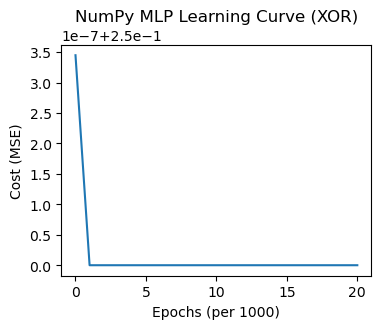


NumPy MLP Predictions on XOR data:
Input: [0. 0.], True: 0.0, Predicted: 0.5000 (Rounded: 1.0)
Input: [0. 1.], True: 1.0, Predicted: 0.5000 (Rounded: 0.0)
Input: [1. 0.], True: 1.0, Predicted: 0.5000 (Rounded: 1.0)
Input: [1. 1.], True: 0.0, Predicted: 0.5000 (Rounded: 0.0)


In [75]:
# 学習の実行
print("NumPy MLP 学習開始 (XORデータ)...")
trained_params_np, costs_np = train_mlp_np(X_xor, y_xor, hidden_size=2, num_epochs=20000, learning_rate=0.5)

# 学習曲線のプロット
plt.figure(figsize=(4,3))
plt.plot(costs_np)
plt.xlabel(f"Epochs (per {1000})")
plt.ylabel("Cost (MSE)")
plt.title("NumPy MLP Learning Curve (XOR)")
plt.show()

# 学習済みモデルで予測
predictions_np, _ = forward_propagation(X_xor, trained_params_np)
print("\nNumPy MLP Predictions on XOR data:")
for i in range(X_xor.shape[0]):
    print(f"Input: {X_xor[i]}, True: {y_xor[i][0]}, Predicted: {predictions_np[i][0]:.4f} (Rounded: {np.round(predictions_np[i][0])})")

## 2. PyTorchによるMLPの実装
次に、同じXOR問題をPyTorchを使って解いてみます。PyTorchのようなディープラーニングフレームワークを使うと、多くの処理が自動化・効率化されます。

### 2.1 必要なライブラリのインポート

In [76]:
import torch
import torch.nn as nn
import torch.optim as optim
print("PyTorch Version:", torch.__version__)

PyTorch Version: 2.7.0+cpu


### 2.2 データとモデルの準備

PyTorchでは、データを`torch.Tensor`型で扱います。
モデルは`torch.nn.Module`を継承して定義するのが一般的です。

In [77]:
# numpy配列をPyTorchのテンソルに変換
X_xor_torch = torch.from_numpy(X_xor).float()
y_xor_torch = torch.from_numpy(y_xor).float()

print("\nXOR入力データ (X_xor_torch):\n", X_xor_torch)
print("\nXOR出力データ (y_xor_torch):\n", y_xor_torch)


XOR入力データ (X_xor_torch):
 tensor([[0., 0.],
        [0., 1.],
        [1., 0.],
        [1., 1.]])

XOR出力データ (y_xor_torch):
 tensor([[0.],
        [1.],
        [1.],
        [0.]])


In [78]:
# MLPモデルの定義
class mlp_torch(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(mlp_torch, self).__init__()
        # nn.Linearは全結合層を表す
        self.hidden_layer = nn.Linear(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
        # self.relu = nn.ReLU() # ReLUを使用する場合
    
    def forward(self, x):
        '''順伝播の定義'''
        x = self.hidden_layer(x)
        x = self.sigmoid(x)
        x = self.output_layer(x)
        x = self.sigmoid(x)
        return x
    
# モデルのインスタンス化
model_torch = mlp_torch(input_size=X_xor.shape[1], hidden_size=2, output_size=y_xor.shape[1])
print('\nPyTorch MLP Model:', model_torch)


PyTorch MLP Model: mlp_torch(
  (hidden_layer): Linear(in_features=2, out_features=2, bias=True)
  (output_layer): Linear(in_features=2, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


### 2.3 損失関数とOptimizerの定義

PyTorchには様々な損失関数とOptimizerが用意されています。

In [79]:
# 損失関数（平均二乗誤差）
criterion = nn.MSELoss()
# criterion = nn.BCELoss()  # バイナリ交差エントロピーを使用する場合

# Optimizer（確率勾配降下法 - SGD）
# model_torch.parameters()  # モデル内の学習可能な全パラメータを取得
learning_rate = 0.5
optimizer = optim.SGD(model_torch.parameters(), lr=learning_rate)
# optimizer = optim.Adam(model_torch.parameters(), lr=learning_rate)  # Adamを使用する場合

### 2.4 PyTorchモデルの学習ループ

PyTorchの学習ループは以下のようになります。

1.  Optimizerの勾配をリセット (`optimizer.zero_grad()`)。
2.  **順伝播**: モデルに入力データを通して予測値を得る (`outputs = model(inputs)`)。
3.  **損失計算**: 予測値と真の値から損失を計算する (`loss = criterion(outputs, labels)`)。
4.  **逆伝播**: 損失から勾配を自動計算する (`loss.backward()`)。**これがPyTorchの自動微分機能 (`autograd`) です。**
5.  **パラメータ更新**: Optimizerを使ってパラメータを更新する (`optimizer.step()`)。

In [80]:
def train_mlp_torch(model, criterion, optimizer, X, y, num_epochs=10000, print_cost_every=1000):
    '''
    PytorchでMLPを学習する関数
    '''
    cost = []
    for epoch in range(num_epochs + 1):
        # 順伝播
        outputs = model(X)

        # 損失関数
        loss = criterion(outputs, y)

        # 逆伝播とパラメータ更新
        optimizer.zero_grad() # 前のステップの勾配をゼロにリセット
        loss.backward() # 損失から勾配を計算
        optimizer.step() # 計算された勾配を使ってパラメータを更新

        if epoch % print_cost_every == 0:
            cost.append(loss.item())
            print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item():.4f}")
    
    return cost


PyTorch MLP 学習開始 (XORデータ)...
Epoch 0/20000, Loss: 0.2513
Epoch 1000/20000, Loss: 0.2489
Epoch 2000/20000, Loss: 0.1442
Epoch 3000/20000, Loss: 0.0089
Epoch 4000/20000, Loss: 0.0037
Epoch 5000/20000, Loss: 0.0022
Epoch 6000/20000, Loss: 0.0016
Epoch 7000/20000, Loss: 0.0012
Epoch 8000/20000, Loss: 0.0010
Epoch 9000/20000, Loss: 0.0008
Epoch 10000/20000, Loss: 0.0007
Epoch 11000/20000, Loss: 0.0006
Epoch 12000/20000, Loss: 0.0006
Epoch 13000/20000, Loss: 0.0005
Epoch 14000/20000, Loss: 0.0005
Epoch 15000/20000, Loss: 0.0004
Epoch 16000/20000, Loss: 0.0004
Epoch 17000/20000, Loss: 0.0004
Epoch 18000/20000, Loss: 0.0003
Epoch 19000/20000, Loss: 0.0003
Epoch 20000/20000, Loss: 0.0003


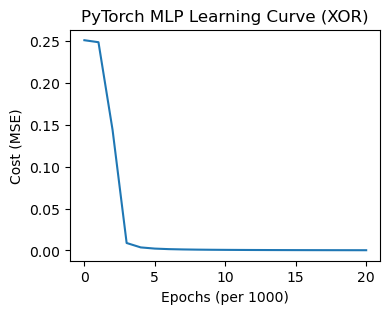


PyTorch MLP Predictions on XOR data:
Input: [0. 0.], True: 0.0, Predicted: 0.0173 (Rounded: 0.0)
Input: [0. 1.], True: 1.0, Predicted: 0.9838 (Rounded: 1.0)
Input: [1. 0.], True: 1.0, Predicted: 0.9802 (Rounded: 1.0)
Input: [1. 1.], True: 0.0, Predicted: 0.0154 (Rounded: 0.0)


In [81]:
# 学習の実行
print("\nPyTorch MLP 学習開始 (XORデータ)...")
costs_torch = train_mlp_torch(model_torch, criterion, optimizer, X_xor_torch, y_xor_torch, 
                                num_epochs=20000, print_cost_every=1000)


# 学習曲線のプロット
plt.figure(figsize=(4,3))
plt.plot(costs_torch)
plt.xlabel(f"Epochs (per {1000})")
plt.ylabel("Cost (MSE)")
plt.title("PyTorch MLP Learning Curve (XOR)")
plt.show()

# 学習済みモデルで予測
with torch.no_grad(): # 勾配計算をしないモード (予測時)
    predictions_torch = model_torch(X_xor_torch)
    
print("\nPyTorch MLP Predictions on XOR data:")
for i in range(X_xor_torch.shape[0]):
    pred_val = predictions_torch[i].item()
    print(f"Input: {X_xor[i]}, True: {y_xor[i][0]}, Predicted: {pred_val:.4f} (Rounded: {np.round(pred_val)})")

## 3. NumPy実装とPyTorch実装の比較と考察

### 3.1 コードの記述量と可読性

*   **NumPy:**
    *   順伝播、活性化関数、損失関数、逆伝播、パラメータ更新の全てを明示的に実装する必要がある。
    *   コード量は多くなりがちだが、各ステップの計算内容が直接的にコードに現れるため、アルゴリズムの理解には役立つ。
*   **PyTorch:**
    *   `nn.Module` や `nn.Linear`、組み込みの活性化関数・損失関数、`optim` を使うことで、モデル定義や学習ループが非常に簡潔になる。
    *   特に逆伝播（バックプロパゲーション）は `loss.backward()` の一行で完了するため、複雑なモデルでも勾配計算の間違いを心配する必要が少ない。
    *   高レベルなAPIにより、コードの可読性が向上し、モデルの構造に集中できる。

### 3.2 勾配計算

*   **NumPy:**
    *   手動で連鎖律に基づいて偏微分を計算し、バックプロパゲーションのロジックを実装する必要がある。
    *   実装が複雑で、間違いやすく、デバッグも困難な場合がある（勾配チェックが重要）。
*   **PyTorch:**
    *   `autograd`システムにより、計算グラフを自動的に構築し、`backward()`メソッドを呼び出すだけで、全ての学習可能パラメータに対する勾配が自動的に計算される。
    *   これにより、開発者は勾配計算の詳細を意識する必要がなくなり、新しいモデル構造や損失関数の試行が容易になる。

### 3.3 柔軟性と拡張性

*   **NumPy:**
    *   全てを自分で制御できるため、非常に柔軟性が高い。特殊な演算やカスタムな学習ルールを実装しやすい。
    *   しかし、新しい層や活性化関数、Optimizerを追加するたびに、順伝播と逆伝播の両方を手動で実装・修正する必要があり、拡張性は低い。
*   **PyTorch:**
    *   多くの一般的な層、活性化関数、Optimizerが提供されており、それらを組み合わせることで容易に複雑なモデルを構築できる。
    *   カスタムな`nn.Module`を作成することで、独自のコンポーネントも容易に組み込める。自動微分機能により、新しいモジュールの勾配計算も自動で行われるため、拡張性が高い。

### 3.4 GPUサポートとパフォーマンス

*   **NumPy:**
    *   基本的にCPUでの計算。GPUを使うにはCuPyのような別のライブラリが必要。
    *   大規模なデータや複雑なモデルでは、Pythonの実行速度とNumPyのCPUバウンドな計算がボトルネックになり得る。
*   **PyTorch:**
    *   `.to('cuda')` のように簡単にテンソルやモデルをGPUに転送でき、GPUアクセラレーションの恩恵を容易に受けられる。
    *   内部はC++やCUDAで最適化されており、大規模な計算でも高いパフォーマンスを発揮する。

### 3.5 まとめ

*   **NumPyによるスクラッチ実装**は、ディープラーニングの基本的な構成要素やアルゴリズムの内部動作を深く理解するためには非常に有益です。順伝播や逆伝播を自分の手で実装することで、何が起こっているのかを具体的に把握できます。
*   **PyTorchのようなフレームワーク**は、これらの低レベルな詳細を抽象化し、自動微分、GPUサポート、豊富なモジュールを提供することで、研究者や開発者がより迅速かつ効率的に高度なモデルを構築・実験できるようにします。